Step 1 - Import python libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

pd.options.mode.chained_assignment = None

Step 2 - Load and read your data file
- pyTCR accepts a single `.tsv` file that should contain all the samples.
  - The following cell attempts to detect whether you are running the notebook in a Google Colab cloud environment or in a local environment, and then loads the data at the specified path.
- The `filePath` variable in the following code cell should be changed to the location of your file. The following options are supported:
  1. A `filePath` from Google Drive (to run on a cloud environment)
  2. A `filePath` from your local computer (to run on a local environment, other cloud environments should work as expected)
- The `data_adapter` notebook can be used to convert the data into the correct format for pyTCR to read.

In [2]:
# Specify the path to your data in Google Drive or locally
filePath = "../data/complete_COVID_SAMPLES.tsv" 

df = pd.read_table(filePath, low_memory=False, engine="c")

optional_fields = ['hospitalized']

df.head()

,sample,frequency,templates,amino_acid,rearrangement,v_resolved,d_resolved,j_resolved,age,gender,...,icu_admit,birth_year,blood_type,cmv_at_donation,days_from_last_symptom_to_sample,ethnicity,height_meters,hospitalized,weight_kg,race
0,6232BW_TCRB,0.006751,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
1,6232BW_TCRB,0.005639,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
2,6232BW_TCRB,0.004258,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
3,6232BW_TCRB,0.003639,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
4,6232BW_TCRB,0.003521,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian


Step 3 - Create the standardized format (column content and column names)

- Sample name (sample)
- Clone frequency (freq)
- Clone reads count (#count)
- CDR3 amino acid clonotype (cdr3aa)
- CDR3 nucleotide (cdr3nt)
- V gene (v)
- D gene (d)
- J gene (j)
- Optional fields (here we use hospitalization as the clinical feature)

In [3]:
# Select the columns that are listed above
df = df[['sample','frequency', 'templates', 'amino_acid', 'rearrangement', 'v_resolved', 'd_resolved','j_resolved','hospitalized']]

# Rename the columns 
df.columns = ['sample', 'freq' , '#count' , 'cdr3aa' , 'cdr3nt' , 'v' , 'd' , 'j' , 'hospitalized']

df.head()

,sample,freq,#count,cdr3aa,cdr3nt,v,d,j,hospitalized
0,6232BW_TCRB,0.006751,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,True
1,6232BW_TCRB,0.005639,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,True
2,6232BW_TCRB,0.004258,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,True
3,6232BW_TCRB,0.003639,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,True
4,6232BW_TCRB,0.003521,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,True


Relative abundance (in all clonotypes)

In [4]:
# Define clonotype groups based on frequency
def clonotype_group (row):
    if row['freq'] > 0.01 and row['freq'] <= 1:
        return 'Hyperexpanded'
    if row['freq'] > 0.001 and row['freq'] <= 0.01: 
        return 'Large'
    if row['freq'] > 0.0001 and row['freq'] <= 0.001:
        return 'Medium'
    if row['freq'] > 0.00001 and row['freq'] <= 0.0001:
        return 'Small'
    if row['freq'] > 0 and row['freq'] <= 0.00001:
        return 'Rare'

# Apply the clonotype_group function to the dataframe
df['clonotype_group'] = df.apply (lambda row: clonotype_group(row),axis=1)

# Calculate the relative abundance in each sample based on clonotype groups
df_relative_abundance= df.groupby(['sample','hospitalized','clonotype_group']).agg({'freq':'sum'}).reset_index().rename(columns={'':"relative_abundance"})
df_relative_abundance

,sample,hospitalized,clonotype_group,freq
0,1132289BW_TCRB,False,Large,0.014510
1,1132289BW_TCRB,False,Medium,0.048889
2,1132289BW_TCRB,False,Rare,0.635481
3,1132289BW_TCRB,False,Small,0.120081
4,1222568BW_TCRB,False,Large,0.042535
...,...,...,...,...
209,964229BW_TCRB,False,Small,0.104677
210,989003BW_TCRB,True,Large,0.024762
211,989003BW_TCRB,True,Medium,0.026716
212,989003BW_TCRB,True,Rare,0.667887


## FigureS3a

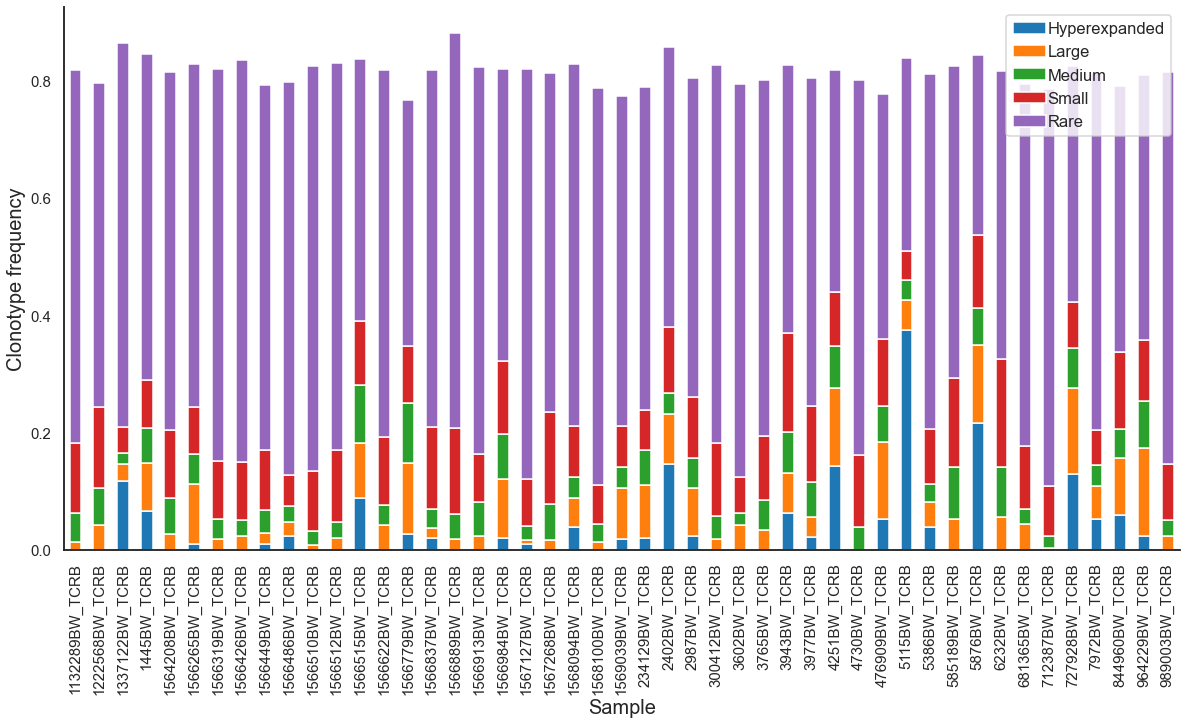

In [5]:
sns.set_style("white") 
sns.set_context("talk")

label_order = ['Hyperexpanded', 'Large', 'Medium', 'Small', 'Rare']

ax = df_relative_abundance.groupby(['sample','clonotype_group'])['freq'].sum().unstack()[label_order].plot(kind='bar', stacked=True)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:], labels[0:], loc='upper right', bbox_to_anchor=(1, 1), handletextpad=0.1)

ax.set_xlabel('Sample',fontsize=20)
ax.set_ylabel('Clonotype frequency',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gcf().set_size_inches(20,10)
sns.despine()

plt.savefig("../figures/supplementary/figureS3a.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS3a.png",bbox_inches="tight")

plt.show()

Relative abundance in top clonotypes

In [6]:
# Define groups based on clone counts 
def reads_group_top (row):
    if row['#count'] > 1 and row['#count'] <= 10:
        return '1-10'
    if row['#count'] >= 11 and row['#count'] <= 100:
        return '11-100'
    if row['#count'] >= 101 and row['#count'] <= 1000:
        return '101-1000'
    if row['#count'] >= 1001 and row['#count'] <= 5000:
        return '1001-5000'

# Get the top 100 clonotypes in each sample
df_top=df.sort_values(['sample', 'freq'], axis=0).groupby('sample').tail(100)

# Apply the function to the dataframe
df_top['reads_group'] = df_top.apply (lambda row: reads_group_top(row),axis=1)

# Show the result
df_top_result = df_top[['sample','hospitalized','reads_group']]
df_top_result

,sample,hospitalized,reads_group
13483113,1132289BW_TCRB,False,101-1000
13483114,1132289BW_TCRB,False,101-1000
13483112,1132289BW_TCRB,False,101-1000
13483111,1132289BW_TCRB,False,101-1000
13483110,1132289BW_TCRB,False,101-1000
...,...,...,...
437916,989003BW_TCRB,True,1001-5000
437915,989003BW_TCRB,True,1001-5000
437914,989003BW_TCRB,True,1001-5000
437913,989003BW_TCRB,True,1001-5000


## FigureS3b

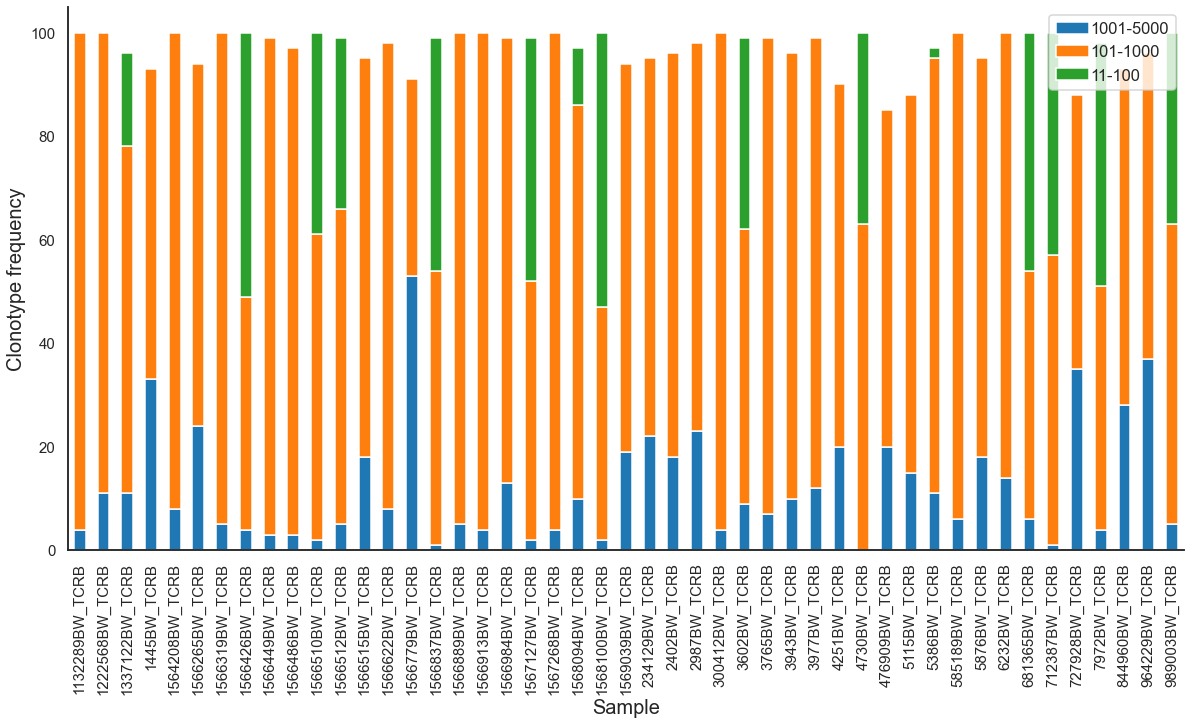

In [7]:
sns.set_style("white") 
sns.set_context("talk")

ax = df_top.groupby(['sample', 'reads_group'])['#count'].count().unstack().plot(kind='bar', stacked=True)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:], labels[0:], loc='upper right', bbox_to_anchor=(1, 1), handletextpad=0.1)

ax.set_xlabel('Sample',fontsize=20)
ax.set_ylabel('Clonotype frequency',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gcf().set_size_inches(20,10)
sns.despine()

plt.savefig("../figures/supplementary/figureS3b.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS3b.png",bbox_inches="tight")

plt.show()

Relative abundance in rare clonotypes

In [8]:
# Define groups based on clone counts 
def reads_group_rare (row):
    if row['#count'] == 1 :
        return '1'
    if row['#count'] >= 2 and row['#count'] <= 3:
        return '2-3'
    if row['#count'] >= 4 and row['#count'] <= 10:
        return '4-10'
    if row['#count'] >= 11 and row['#count'] <= 30:
        return '11-30'
    if row['#count'] >= 31 and row['#count'] <= 100:
        return '31-100'  
    if row['#count'] >= 101 and row['#count'] <= 200:
        return '101-200'

# Get the rare 100 clonotypes
df_rare=df.sort_values(['sample', 'freq'], axis=0).groupby('sample').head(100)

# Apply the functions to the dataframe
df_rare['reads_group'] = df_rare.apply (lambda row: reads_group_rare(row),axis=1)

# Show the result
df_rare_result = df_rare[['sample','hospitalized','reads_group']]
df_rare_result

,sample,hospitalized,reads_group
13533460,1132289BW_TCRB,False,1
13533461,1132289BW_TCRB,False,1
13533462,1132289BW_TCRB,False,1
13533463,1132289BW_TCRB,False,1
13533464,1132289BW_TCRB,False,1
...,...,...,...
486385,989003BW_TCRB,True,1
486386,989003BW_TCRB,True,1
486387,989003BW_TCRB,True,1
486388,989003BW_TCRB,True,1


## Figure3c

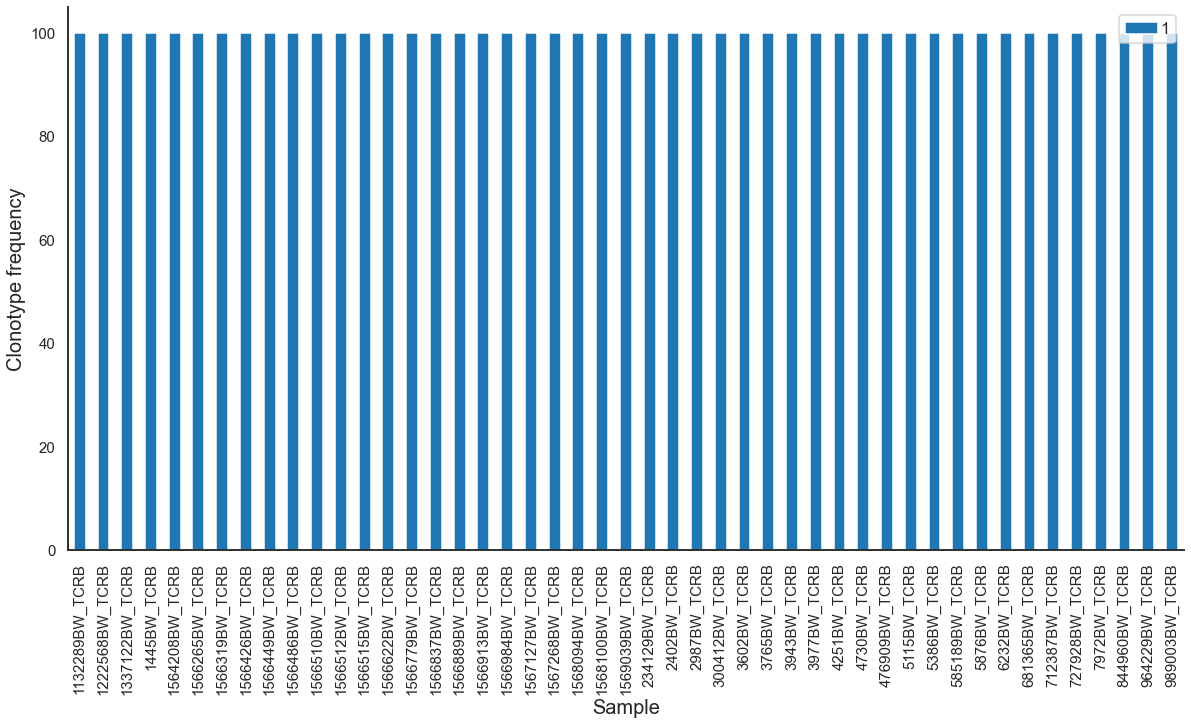

In [9]:
sns.set_style("white") 
sns.set_context("talk")

ax = df_rare.groupby(['sample', 'reads_group'])['#count'].count().unstack().plot(kind='bar', stacked=True)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:], labels[0:], loc='upper right', bbox_to_anchor=(1, 1), handletextpad=0.1)

ax.set_xlabel('Sample',fontsize=20)
ax.set_ylabel('Clonotype frequency',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gcf().set_size_inches(20,10)
sns.despine()

plt.savefig("../figures/supplementary/figureS3c.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS3c.png",bbox_inches="tight")

plt.show()